# Ground-level ozone predictions

## About this notebook

Ozone can be good or bad depending on where it is found. In the upper atmosphere it occurs naturally and forms the famous ozone shield that protect us from the sun's ultraviolet radiation. At ground level, ozone is formed by the action of sunlight on certain pollutants and if it reaches high levels, it can be dangerous for our health and the environment. 

In this notebook I study the [Ozone Level Detection Dataset](https://archive.ics.uci.edu/ml/datasets/Ozone+Level+Detection) from UCI Machine Learning Repository and try to classify days in "ozone days" or "normal days". An "ozone day" is a day with high levels of ground-level ozone.

## Table of contents

* 1: [Dataset loading](#data)
* 2: [Preprocessing](#preprocessing)
* 3: [Feature selection](#feature_selection)
* 4: [Predictive models](#predictive_models)
    * 4.1: [Training and test sets](#sets)
    * 4.2: [Model 1: Random Forest](#rf)
        * 4.2.1: [Search of best hyperparameters using imblearn.pipeline](#hyperparams_pipeline)
        * 4.2.2: [Search of best hyperparameters in a "homemade" way](#hyperparams_homemade)
        * 4.2.3: [Model evaluation](#model_evaluation)
    * 4.3: [Model 2: Support Vector Machine](#svm)
        * 4.3.1: [Search of best hyperparameters using imblearn.pipeline](#hyperparams_pipeline_svm)
        * 4.3.2: [Model evaluation](#model_evaluation_svm)
* 5: [Conclusions](#conclusions)


<a name='data'></a>
## 1. Dataset loading 

The dataset contains two files with information collected from 1998 to 2004 at the Houston, Galveston and Brazoria area. One is the eight hour peak set (`eighthr.data`), the other is the one hour peak set (`onehr.data`). Here, I use the first one. The column names are in the file `eighthr.names`.

Some characteristics of the data:
- The dataset is imbalanced. Only 6.5% of the days belong to the class "ozone days".
- It contains a lot of missing data.
- It has a small number of examples and a large number of features. 

Let's load the dataset.

In [61]:
# Import libraries.
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV 
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, precision_recall_curve, f1_score
import matplotlib.colors
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# Load data.
eight_hr = pd.read_csv('./data/eighthr.data', delimiter = ',', header = None)

print(f'The dataset contains {eight_hr.shape[0]} rows and {eight_hr.shape[1]} columns.')  # Shape = 2534 x 74

# Add names to columns.
eight_hr_names = np.loadtxt('./data/eighthr.names', delimiter = ':', skiprows = 2, dtype = str)
columns = list(eight_hr_names[:,0]) 
columns.append('Class')

eight_hr.columns = columns

The dataset contains 2534 rows and 74 columns.


 When inspecting the data I see that, except for the last column, the rest are of object type. In addition, there are missing values.

In [62]:
# Inspect data.
eight_hr.info()
eight_hr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 74 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2534 non-null   object 
 1   WSR0    2534 non-null   object 
 2   WSR1    2534 non-null   object 
 3   WSR2    2534 non-null   object 
 4   WSR3    2534 non-null   object 
 5   WSR4    2534 non-null   object 
 6   WSR5    2534 non-null   object 
 7   WSR6    2534 non-null   object 
 8   WSR7    2534 non-null   object 
 9   WSR8    2534 non-null   object 
 10  WSR9    2534 non-null   object 
 11  WSR10   2534 non-null   object 
 12  WSR11   2534 non-null   object 
 13  WSR12   2534 non-null   object 
 14  WSR13   2534 non-null   object 
 15  WSR14   2534 non-null   object 
 16  WSR15   2534 non-null   object 
 17  WSR16   2534 non-null   object 
 18  WSR17   2534 non-null   object 
 19  WSR18   2534 non-null   object 
 20  WSR19   2534 non-null   object 
 21  WSR20   2534 non-null   object 
 22  

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Class
0,1/1/1998,0.8,1.8,2.4,2.1,2,2.1,1.5,1.7,1.9,...,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0.0
1,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0
2,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0.0
3,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,...,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0.0
4,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,...,?,?,?,?,?,?,?,?,0.58,0.0


<a name='preprocessing'></a>
## 2. Preprocessing

Summary of preprocessing steps:
1. Drop dates column by recommendation of dataset creators.
2. Convert elements to a numeric type.
3. Replace non-numeric values with NaNs. These are the missing values.
4. Drop columns with more than 50% of missing data.
5. Drop samples with more than 50% of missing data.
6. Replace NaNs with the median value of the corresponding feature (column).

In [54]:
count = 0

# Create a new Pandas DataFrame without first column (dates).
data = pd.DataFrame(np.zeros(eight_hr.drop(['Date'], axis = 1).shape)) 
data.columns = columns[1:]

# pd.to_numeric converts elements to a numeric type. Non-numeric values are 
# replaced with NaNs setting errors = 'coerce'.
for col in eight_hr.drop(['Date'], axis = 1).columns:
    data[col] = pd.to_numeric(eight_hr[col], errors = 'coerce')
    count = count + pd.to_numeric(eight_hr[col], errors = 'coerce').notna().sum()

missing_values = data.size - count
print(f'Missing values are {missing_values*100 / data.size:.2f}% of the whole dataset.')
# Percentage of missing values: 8.074839714134349

# Another way to find missing values.
data.replace('?', np.NaN).isnull().sum().sum()

# Percentage of NaNs in each column.
col_nan = []
for col in data.columns:
    col_nan.append([col, data[col].isnull().sum()*100 / data[col].size])

# If the percentage of missing values is higher than 50, discard the column.
col_discard = []
for i in range(len(col_nan)):
    if col_nan[i][1] > 50:        
        col_discard.append(i)
        
if len(col_discard) == 0: 
    print('There are not columns with more than 50% of missing values.')
    
# Percentage of NaNs in each row.    
row_nan = []
for ind in data.index:
    row_nan.append([ind, data.loc[ind].isnull().sum()*100 / data.loc[ind].size])

# If the percentage of missing values is higher than 50, discard the example.
row_discard = []
for i in range(len(row_nan)):
    if row_nan[i][1] > 50:
        row_discard.append(i)

# Drop examples with more than 50% of missing values.
data = data.drop(row_discard)
# data = data.reset_index(drop=True)

# Replace missing values with the median value of the corresponding feature (column).
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer = imputer.fit(data)
data = pd.DataFrame(imputer.transform(data))
data.columns = columns[1:]

print(f'After preprocessing, the dataset contains {data.shape[0]} rows and {data.shape[1]} columns.')

Missing values are 8.07% of the whole dataset.
There are not columns with more than 50% of missing values.
After preprocessing, the dataset contains 2358 rows and 73 columns.


<a name='feature_selection'></a>
## 3. Feature selection

First, let's separate data in features and target. 

For each day I have the following features or attributes:
- WSR0, WSR1, ..., WSR23: Wind speed measured at different time throughout the day.
- WSR_PK: Maximum wind speed.
- WSR_AV: Average wind speed.
- T0, T1, ..., T23: Temperature measured at different time throughout the day.
- T_PK: Maximum temperature.
- T_AV: Average temperature.
- T85, T70, T50: T at 850 hPa level, 700 hPa level and 500 hPa level.
- RH85, RH70, RH50: Relative Humidity at 850 hPa level, 700 hPa level and 500 hPa level.
- U85, U70, U50: U wind (E-W direction) at 850 hPa level, 700 hPa level and 500 hPa level.
- V85, V70, V50: V wind (N-S direction) at 850 hPa level, 700 hPa level and 500 hPa level.
- HT85, HT70, HT50: Geopotential height at 850 hPa level, 700 hPa level and 500 hPa level.
- KI: K-Index. It is a measure of a thunderstorm potential.
- TT: Total Totals index. It is used to assess storm strength. 
- SLP: Sea level pressure.
- SLP_: SLP change from previous day.
- Precp: Precipitation.

About the target variable, it is 0 for "normal days" and 1 for "ozone days". From the plot below, you can check how unbalanced the data is. 

Examples with Class 0: 6.53%
Examples with Class 1: 93.47%


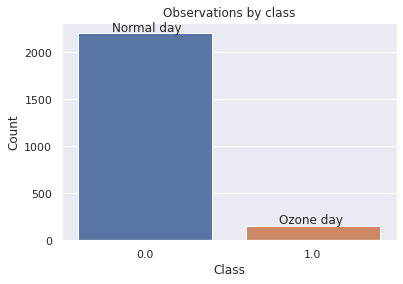

In [31]:
# Features and targets.
X = data.iloc[:, :-1]
y = data.iloc[:, -1]  # 0 is "normal day", 1 is "ozone day"

m = len(y)

# Count observations by class using bars.
plt.figure(1)
sns.set_theme(style = 'darkgrid')
sns.countplot(x = 'Class', data = data)
plt.text(-0.2, 2225, 'Normal day')
plt.text(0.80, 175, 'Ozone day')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Observations by class')

percentage_class1 = (y == 1).sum()*100 / len(y)
percentage_class0 = (y == 0).sum()*100 / len(y)

print(f'Examples with Class 0: {percentage_class1:.2f}%')
print(f'Examples with Class 1: {percentage_class0:.2f}%')

To study dependency between variables, let's calculate the correlation coefficients between them.

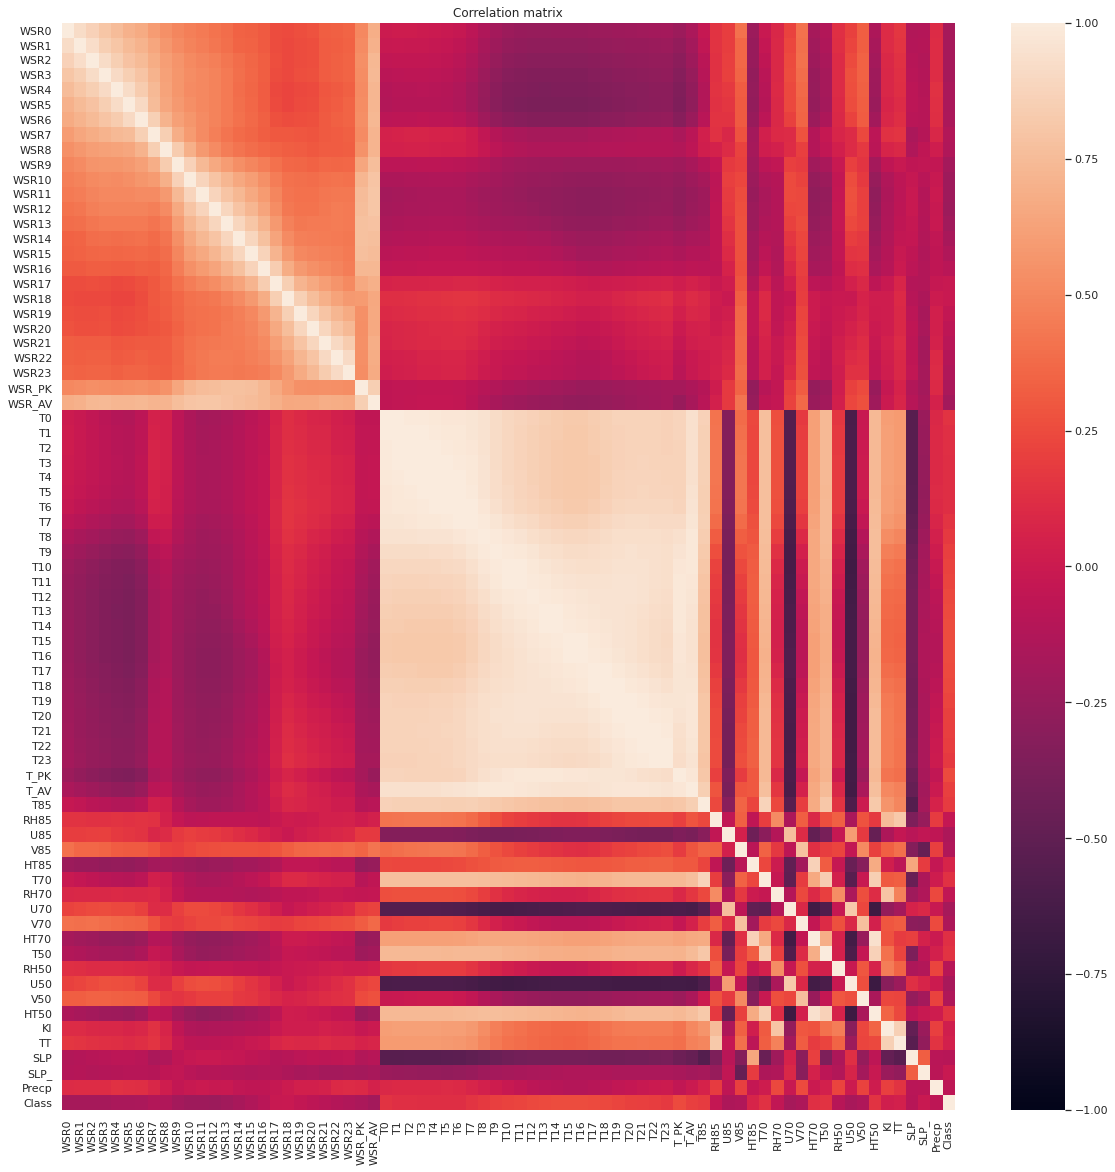

In [32]:
# Correlation matrix.
plt.figure(2, figsize = (20, 20))
sns.heatmap(data.corr(), vmin = -1, vmax = 1)
plt.title('Correlation matrix');

Analyzing the correlation matrix, the first thing that stands out is that the temperature variables are strongly correlated with each other (coefficients higer than 0.8). This means that they share information. 

If I want to reduce the number of input variables, I need to select the most important ones for the predictive model. For doing that, I follow the next steps:
1. Calculate correlation coefficient between target and feature. If it is higher than 0.1, keep the feature.
2. Discard features dependant on each other when correlation coefficient is higher than 0.8.

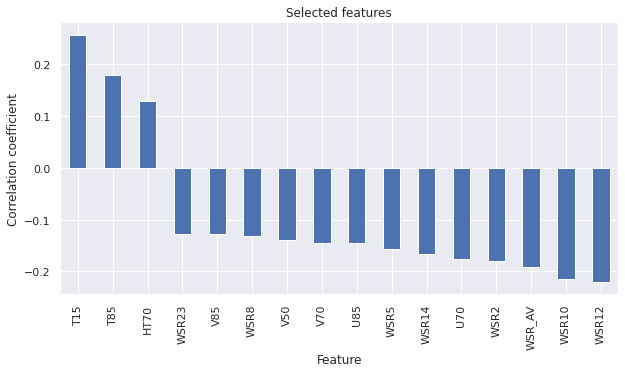

In [33]:
# Select relevant features.
# If correlation between target and feature is higher than 0.1, keep feature.
abs_corr_with_y = abs(X.corrwith(y)).sort_values(ascending = False)

corr_ind = []
for ind in range(len(abs_corr_with_y)):
    if abs_corr_with_y[ind] > 0.1:
        corr_ind.append(abs_corr_with_y.index[ind])

# Discard features dependent on each other.        
corr_ind_relevant = corr_ind.copy()
temp = 0
for i in corr_ind_relevant:
    temp = abs(X[corr_ind_relevant].corrwith(X[i]))
    temp = temp.drop([i])
    for t in temp.index:
        if temp[t] > 0.8:
            corr_ind_relevant.remove(t)
          
corr_relevant_with_y = X[corr_ind_relevant].corrwith(y).sort_values(ascending = False)

plt.figure(3, figsize = (10, 5))
corr_relevant_with_y.plot.bar() 
plt.xlabel('Feature')
plt.ylabel('Correlation coefficient')
plt.title('Selected features');

T15 and WSR12 are the attributes that most correlates with the target variable. From the plots below, we can infere two interesting things:
- On "ozone days" the temparature at 3 p.m (T15) is higher than on "normal days".
- On "ozone days" the wind speed at 12 p.m (WSR12) is lower than on "normal days".

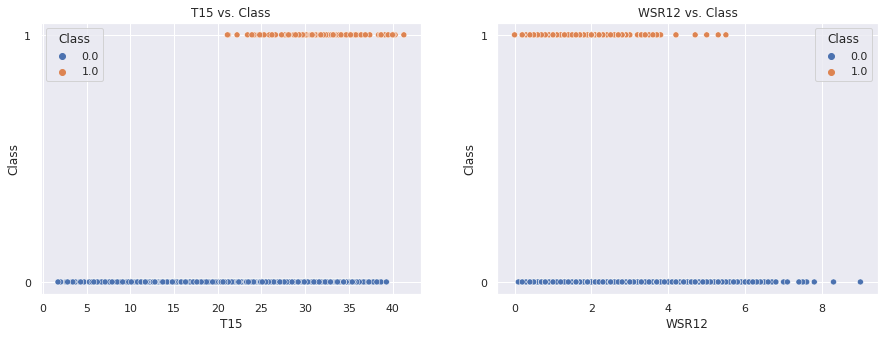

In [34]:
fig4, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5))
# Plot T15 vs. Class.
sns.scatterplot(ax = ax1, x = 'T15', y = 'Class', data = data, hue = 'Class')
ax1.set(yticks = range(0, 2))
ax1.set_title('T15 vs. Class');
# Plot WSR12 vs. Class. 
sns.scatterplot(ax = ax2, x = 'WSR12', y = 'Class', data = data, hue = 'Class')
ax2.set(yticks = range(0, 2))
ax2.set_title('WSR12 vs. Class');

Finally, let’s visualize the distributions of the most relevant variables and verify that there are no outliers or data gaps.

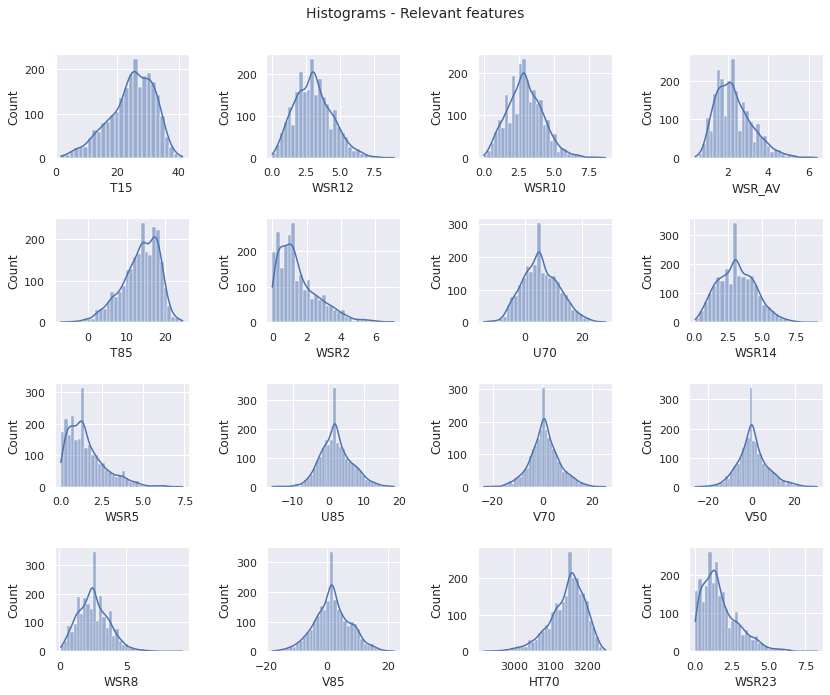

In [35]:
a = 4
b = 4
c = 1 

fig = plt.figure(5, figsize = (12, 10))
for i in X[corr_ind_relevant].columns:
    plt.subplot(a, b, c)
    sns.histplot(X[corr_ind_relevant], x = i, kde = True)
    c = c + 1
fig.suptitle('Histograms - Relevant features', fontsize = 14)
fig.tight_layout(pad = 2.0)

<a name='predictive_models'></a>
## 4. Predictive models

<a name='sets'></a>
### 4.1. Training and test sets

Here, I divide the data into test and training sets, taking care to get the same percentage of "ozone days" on both.

In [36]:
# Split data in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X[corr_ind_relevant], y, test_size = 0.3, 
                                                    random_state = 42, 
                                                    shuffle = True, 
                                                    stratify = y)  # Stratify divides the data based on class values
y_train_counts = y_train.value_counts()
y_test_counts = y_test.value_counts()

y_train_0 = y_train_counts[0]*100 / len(y_train)
y_train_1 = y_train_counts[1]*100 / len(y_train)
y_test_0 = y_test_counts[0]*100 / len(y_test)
y_test_1 = y_test_counts[1]*100 / len(y_test)

print(f'Class 0 in training set: {y_train_0: .2f}%')
print(f'Class 1 in training set: {y_train_1: .2f}%')
print(f'Class 0 in test set: {y_test_0: .2f}%')
print(f'Class 1 in test set: {y_test_1: .2f}%')

Class 0 in training set:  93.45%
Class 1 in training set:  6.55%
Class 0 in test set:  93.50%
Class 1 in test set:  6.50%


<a name='rf'></a>
### 4.2. Model 1: Random Forest

Random forest uses many decision trees at training time. For classification tasks, the output is the class selected by most trees.

<a name='hyperparams_pipeline'></a> 
#### 4.2.1. Search of best hyperparameters using imblearn.pipeline

In this subsection I perform a randomized search of optimal hyperparameters. 

Imagine you have several settings to test. For each of them, you do the following: 
1. K-fold CV to split the training set into k subsets.
2. Take k-1 folds and oversample them using SMOTE. Train the model using a given group of hyperparameters.
3. Validate the model using the remaining fold. Retain the evaluation score.
4. Repeat the previous steps for each of the k fold and average the scores.

Then, after testing different set of parameters, you take the ones that give the best results (best average score). 

Since it is a problem with skewed classes, I use F1-score for evaluation.

In [37]:
# K-fold cross validation.
kf = KFold(n_splits = 5, random_state = None, shuffle = False)

# Parameter space to test.
search_grid = {'randomforestclassifier__max_depth': [5, 10, 20, 40, 80],
               'randomforestclassifier__n_estimators': [50, 100, 200, 400],
               'randomforestclassifier__min_samples_split': [2, 5],
               'randomforestclassifier__min_samples_leaf': [1, 2],
               'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2', None],
               'randomforestclassifier__criterion': ['gini', 'entropy']}

# Create pipeline: 1. Data oversampling. 2. Run Random Forest classifier.
# When using make_pipeline, predict is not applied in the sample step. Therefore, the data is not 
# oversampled when the model is validated. 
imb_pipeline = make_pipeline(SMOTE(random_state = 0), 
                             RandomForestClassifier(random_state = 0))

imb_grid = RandomizedSearchCV(imb_pipeline, 
                              search_grid, 
                              cv = kf, 
                              scoring = 'f1',
                              return_train_score = True, 
                              verbose = 0, 
                              n_iter = 250)

imb_grid.fit(X_train, y_train)
y_pred = imb_grid.predict(X_test)

print('Best parameters:', imb_grid.best_params_)

Best parameters: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'entropy'}


<a name='hyperparams_homemade'></a> 
#### 4.2.2. Search of best hyperparameters in a "homemade" way

This is a parameter optimization without using imblearn.pipeline. The results are the same as the previous ones. 

In [38]:
# List of hyperparameters to try.
param_list = [[5, 10, 20, 40, 80],  # max depth
              [50, 100, 200, 400],  # n_estimators
              [2, 5],  # min_samples_split
              [1, 2],  # min_samples_leaf
              ['auto', 'sqrt', 'log2', None],  # max_features
              ['gini', 'entropy']]  # criterion

param_grid = []
for param0, param1, param2, param3, param4, param5 in itertools.product(*param_list):
    param_grid.append({'max_depth': param0, 
                       'n_estimators': param1, 
                       'min_samples_split': param2, 
                       'min_samples_leaf': param3, 
                       'max_features': param4, 
                       'criterion': param5, 
                       'random_state': 0})

# Oversampling technique.
sm = SMOTE(random_state = 0)

cv_score_kfolds = []
cv_score = []
for i in range(len(param_grid)):
    cv_score_kfold = []
    # Divide training set into k consecutive groups (folds).
    # Use k-1 folds for training and the remaining one for validation.
    # Repeat k times.
    for train_fold_idx, cv_idx in kf.split(X_train, y_train):
        X_train_fold, X_cv = X_train.iloc[train_fold_idx], X_train.iloc[cv_idx]
        y_train_fold, y_cv = y_train.iloc[train_fold_idx], y_train.iloc[cv_idx] 
        # Oversample the new training set.
        X_train_fold_os, y_train_fold_os = sm.fit_resample(X_train_fold, y_train_fold)    
        # Train Random Forest with the new training set.
        model = RandomForestClassifier(**param_grid[i]).fit(X_train_fold_os, y_train_fold_os)  
        # Evaluate the model using de validation set.
        cv_score_kfold.append(f1_score(y_cv, model.predict(X_cv)))            
    cv_score_kfolds.append(cv_score_kfold)        
    # Average the k scores.
    cv_score.append(np.mean(cv_score_kfolds[i]))

# Take the highest score. 
idx_cv_score_max = np.argmax(cv_score)
best_params = param_grid[idx_cv_score_max] 
print(best_params)

{'max_depth': 10, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'criterion': 'entropy', 'random_state': 0}


<a name='model_evaluation'></a> 
#### 4.2.3. Model evaluation

Using the parameters detailed above, the F1-score for the test set is around 0.42. Below, I show the confusion matrix.

In [39]:
print(f'Training set F1-score: {imb_grid.score(X_train, y_train):.2f}')
print(f'Validation set F1-score: {imb_grid.best_score_:.2f}')
print(f'Test set F1-score: {imb_grid.score(X_test, y_test):.2f}')

Training set F1-score: 0.76
Validation set F1-score: 0.38
Test set F1-score: 0.42


Test set Recall: 0.63
Test set Precision: 0.31


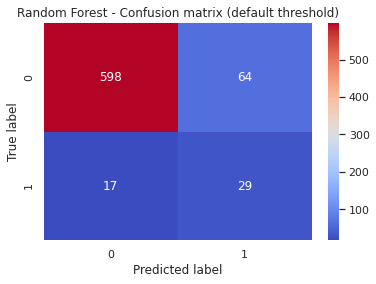

In [40]:
# Plot confusion matrix.
cm = confusion_matrix(y_test, y_pred)

plt.figure(6)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'coolwarm');
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest - Confusion matrix (default threshold)');

print(f'Test set Recall: {recall_score(y_test, y_pred):.2f}')
print(f'Test set Precision: {precision_score(y_test, y_pred):.2f}')

The model predicts correctly a 60% of all positive examples ("ozone days"). In addition, when the model predicts a day as "ozone day", it is right around 30% of the time.

Let's plot the Precision-Recall curve.

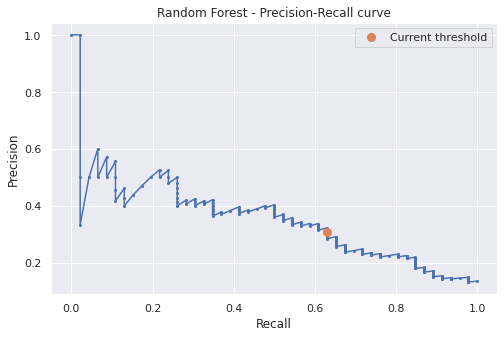

In [41]:
# Plot Precision-Recall curve and current decision threshold.
prob = imb_grid.predict_proba(X_test) # Probabilities
prob_pos = prob[:,1] # Keep probabilities for Class 1
precision, recall, threshold = precision_recall_curve(y_test, prob_pos)
current_threshold_idx = np.abs(threshold - 0.5).argmin()

plt.figure(7, figsize = (8, 5))
plt.plot(recall, precision, '-o', markersize = 2)
plt.plot(recall[current_threshold_idx], precision[current_threshold_idx], 'o', 
         markersize = 8, label = 'Current threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest - Precision-Recall curve')
plt.legend();

The current decision threshold is 0.5 (value taken by default), which means that the model predicts "ozone days" if the estimated probability is more than 0.5.

From the Precision-Recall curve plotted above, it is possible to choose another decision threshold that maximizes the F1-score.


In [55]:
# Calculate threshold where F1-score is maximum.
fscore = (2*precision*recall) / (precision+recall)
idx_fscore_max = np.argmax(fscore)
threshold_fscore_max = threshold[idx_fscore_max]

print(f'Best F1-score is {np.max(fscore):.2f} when threshold is {threshold_fscore_max:.2f}.')

Best F1-score is 0.45 when threshold is 0.66.


Let's recalculate the predictions using a decision threshold of 0.66 and plot the confusion matrix.

Test set Recall: 0.50
Test set Precision: 0.40


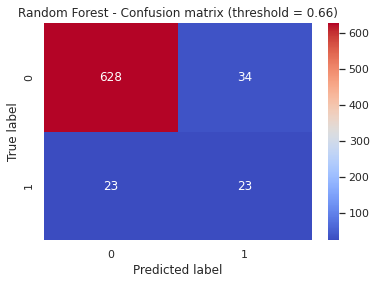

In [56]:
# Calculate predictions using the new threshold (0.66).
y_pred_fscore_max = np.zeros(y_pred.shape)
for i in range(len(y_pred_fscore_max)):
    if prob_pos[i] >= threshold_fscore_max:
        y_pred_fscore_max[i] = 1
    else:
        y_pred_fscore_max[i] = 0

# Plot confusion matrix.
plt.figure(8)
cm_opt = confusion_matrix(y_test, y_pred_fscore_max)
sns.heatmap(cm_opt, annot = True, fmt = 'd', cmap = 'coolwarm');
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest - Confusion matrix (threshold = 0.66)');

print(f'Test set Recall: {recall_score(y_test, y_pred_fscore_max):.2f}')
print(f'Test set Precision: {precision_score(y_test, y_pred_fscore_max):.2f}')

Comparing the results, I think it is preferable to take the threshold of 0.5, so the model can detect as many "ozone days" as possible.

Below, I show two scatter plots where samples are colored according to class. The first one has the test set original data and the second one, the predictions for test set using a decision threshold of 0.5. X-axis is temperature and y-axis is wind.

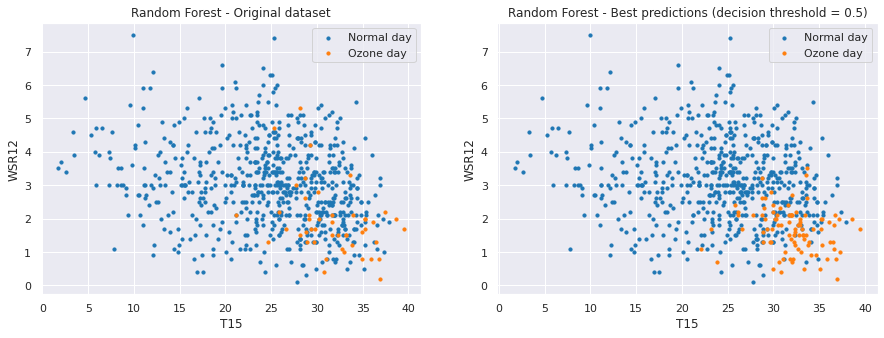

In [44]:
fig9, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5))

# Plot T15 vs. WSR12 using test set original data.
ax1.scatter(X_test['T15'][y_test == 0], X_test['WSR12'][y_test == 0], color = '#1f77b4', s = 10, label = 'Normal day')
ax1.scatter(X_test['T15'][y_test == 1], X_test['WSR12'][y_test == 1], color = '#ff7f0e', s = 10, label = 'Ozone day')
ax1.set_xlabel('T15')
ax1.set_ylabel('WSR12')
ax1.set_title('Random Forest - Original dataset')
ax1.legend()

# Plot T15 vs. WSR12 predictions for test set. 
ax2.scatter(X_test['T15'][y_pred == 0], X_test['WSR12'][y_pred == 0], color = '#1f77b4', s = 10, label = 'Normal day')
ax2.scatter(X_test['T15'][y_pred == 1], X_test['WSR12'][y_pred == 1], color = '#ff7f0e', s = 10, label = 'Ozone day')
ax2.set_xlabel('T15')
ax2.set_ylabel('WSR12')
ax2.set_title('Random Forest - Best predictions (decision threshold = 0.5)')
ax2.legend();

<a name='svm'></a> 
### 4.3. Model 2: Support Vector Machine (SVM)

Here, I use Support Vector Machine (SVM) to make predicitions. This algorithm tries to find the hyperplane that best divides the space and classifies the data points into classes. Since the problem requires a non-linear model, the ideal kernels could be poly or RBF.

<a name='hyperparams_pipeline_svm'></a> 
#### 4.3.1. Search of best hyperparameters using imblearn.pipeline

For hyperparameter optimization I use the same method as in section 4.2.1.

In [45]:
# Parameter space to test.
search_grid_svm = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
                   'svc__kernel': ['poly', 'rbf'],
                   'svc__degree': [3, 6, 9, 12],
                   'svc__gamma': ['scale', 'auto'],
                   'svc__class_weight': ['balanced', None]}

# Create pipeline: 1. Data oversampling. 2. Standardize features by removing the mean and scaling to unit variance.
# 3. Train SVM model.
# When using make_pipeline, predict is not applied in the sample step. Therefore, the data is not 
# oversampled when the model is validated. 
imb_pipeline_svm = make_pipeline(SMOTE(random_state = 0), StandardScaler(), 
                                  SVC(probability = True, random_state = 0))

imb_grid_svm = RandomizedSearchCV(imb_pipeline_svm, 
                                  search_grid_svm, 
                                  cv = kf, 
                                  scoring = 'f1', 
                                  return_train_score = True, 
                                  verbose = 0,
                                  n_iter = 150)

imb_grid_svm.fit(X_train, y_train)

y_pred_svm = imb_grid_svm.predict(X_test)

print('Best parameters:', imb_grid_svm.best_params_)

Best parameters: {'svc__kernel': 'rbf', 'svc__gamma': 'scale', 'svc__degree': 12, 'svc__class_weight': None, 'svc__C': 1}


<a name='model_evaluation_svm'></a> 
#### 4.3.2. Model evaluation

Using the parameters found in the previous step, the F1-score for the test set is 0.38, a lower score than both Random Forest models.

In [46]:
print(f'Training set F1-score: {imb_grid_svm.score(X_train, y_train):.2f}')
print(f'Validation set F1-score: {imb_grid_svm.best_score_:.2f}')
print(f'Test set F1-score: {imb_grid_svm.score(X_test, y_test):.2f}')

Training set F1-score: 0.52
Validation set F1-score: 0.37
Test set F1-score: 0.38


Test set Recall: 0.65
Test set Precision: 0.27


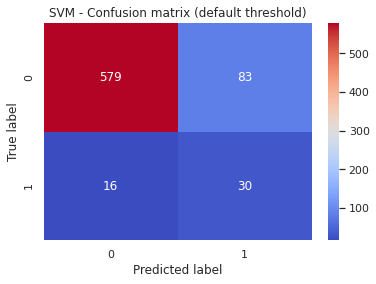

In [47]:
# Plot confusion matrix.
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(10)
sns.heatmap(cm_svm, annot = True, fmt = 'd', cmap = 'coolwarm');
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('SVM - Confusion matrix (default threshold)');

print(f'Test set Recall: {recall_score(y_test, y_pred_svm):.2f}')
print(f'Test set Precision: {precision_score(y_test, y_pred_svm):.2f}')

The decision function gives the distance of each sample to the separation hyperplane. If the value is greater than 0, the point is classified as class 1 ("ozone day").

Let's plot the Precision-Recall curve. Here, the thresholds are not probabilities. They are values of the decision function.  

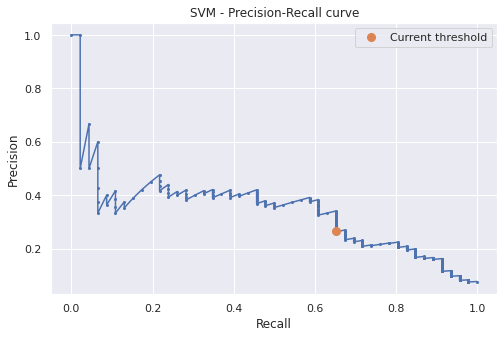

In [52]:
# Plot Precision-Recall curve.
# Decision function indicates which side of the hyperplane a point lies on. 
decision_function = imb_grid_svm.decision_function(X_test) 
precision_svm, recall_svm, threshold_svm = precision_recall_curve(y_test, decision_function)
current_recall_svm_idx = np.abs(recall_svm - recall_score(y_test, y_pred_svm)).argmin()
current_precision_svm_idx = np.abs(precision_svm - precision_score(y_test, y_pred_svm)).argmin()

plt.figure(11, figsize = (8, 5))
plt.plot(recall_svm, precision_svm, '-o', markersize = 2)
plt.plot(recall_svm[current_recall_svm_idx], precision_svm[current_precision_svm_idx], 'o', 
         markersize = 8, label = 'Current threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SVM - Precision-Recall curve')
plt.legend();

Next, I change the decision threshold and see what happens to the metrics.

In [49]:
# Calculate decision threshold where F1-score is maximum.
fscore_svm = (2*precision_svm*recall_svm) / (precision_svm+recall_svm)
idx_fscore_svm_max = np.argmax(fscore_svm)
threshold_fscore_svm_max = threshold_svm[idx_fscore_svm_max]

print(f'Best F1-score is {np.max(fscore_svm):.2f} when decision threshold is {threshold_fscore_svm_max:.2f}.')

Best F1-score is 0.47 when decision threshold is 0.44.


Test set Recall: 0.61
Test set Precision: 0.38


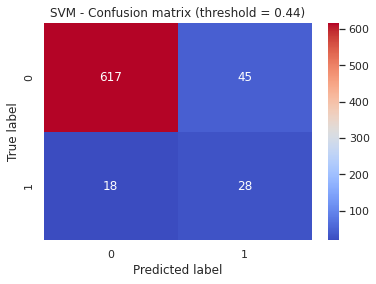

In [60]:
# Calculate predictions using the new decision threshold.
y_pred_fscore_svm_max = np.zeros(y_pred_svm.shape)
for i in range(len(y_pred_fscore_svm_max)):
    if decision_function[i] >= threshold_fscore_svm_max:
        y_pred_fscore_svm_max[i] = 1
    else:
        y_pred_fscore_svm_max[i] = 0

# Plot confusion matrix.
plt.figure(12)
cm_opt_svm = confusion_matrix(y_test, y_pred_fscore_svm_max)
sns.heatmap(cm_opt_svm, annot = True, fmt = 'd', cmap = 'coolwarm');
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('SVM - Confusion matrix (threshold = 0.44)');

print(f'Test set Recall: {recall_score(y_test, y_pred_fscore_svm_max):.2f}')
print(f'Test set Precision: {precision_score(y_test, y_pred_fscore_svm_max):.2f}')

Among the models obtained using decision thresholds 0 and 0.44 (the one that maximizes the F1-score), I think the latter is better because Recall is similar but Precision is much higher.

The following scatter plots compare the original test set with the predictions made by the chosen SVM model.

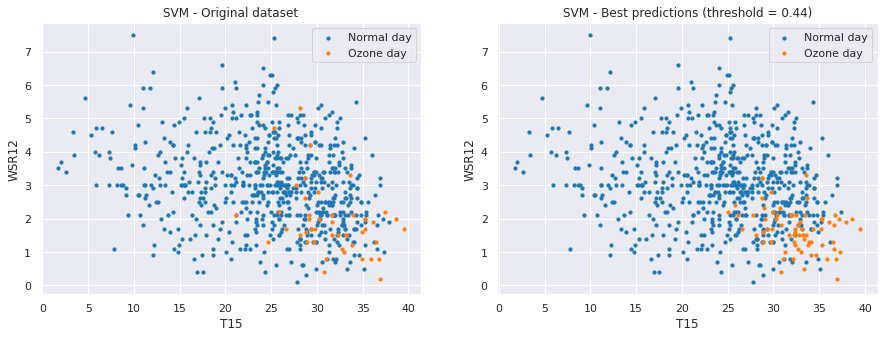

In [58]:
fig13, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5))

# Plot T15 vs. WSR12 using test set original data.
ax1.scatter(X_test['T15'][y_test == 0], X_test['WSR12'][y_test == 0], color = '#1f77b4', s = 10, label = 'Normal day')
ax1.scatter(X_test['T15'][y_test == 1], X_test['WSR12'][y_test == 1], color = '#ff7f0e', s = 10, label = 'Ozone day')
ax1.set_xlabel('T15')
ax1.set_ylabel('WSR12')
ax1.set_title('SVM - Original dataset')
ax1.legend()

# Plot T15 vs. WSR12 predictions for test set. 
ax2.scatter(X_test['T15'][y_pred_fscore_svm_max == 0], X_test['WSR12'][y_pred_fscore_svm_max == 0], color = '#1f77b4', s = 10, label = 'Normal day')
ax2.scatter(X_test['T15'][y_pred_fscore_svm_max == 1], X_test['WSR12'][y_pred_fscore_svm_max == 1], color = '#ff7f0e', s = 10, label = 'Ozone day')
ax2.set_xlabel('T15')
ax2.set_ylabel('WSR12')
ax2.set_title('SVM - Best predictions (threshold = 0.44)')
ax2.legend();

<a name='conclusions'></a>
## 5. Conclusions

The metrics obtained for the four models are shown below. 

| |  | Random Forest | SVM |
|:----:| :----: | :----: | :----: |
| | Recall | 0.63 | 0.65 |
| __Default threshold__ | Precision | 0.31 | 0.27 |
| | F1-score | 0.42 | 0.38 |
| | Recall | 0.50 | __0.61__ |
|__New threshold__ | Precision | 0.40 | __0.38__ |
| | F1-score | 0.45 | __0.47__ |

Looking for the best Recall/Precision trade-off and trying to detect as many "ozone days" as possible, I consider the SVM model with decision threshold 0.44 to be the best choise.